<a href="https://colab.research.google.com/github/SoheilBadri2000/DataScience2/blob/main/39.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, legacy
from keras import initializers
from tqdm import tqdm

In [4]:
# set a seed
np.random.seed(1000)
# se set a dimention of a random vector
random_dim = 100

In [5]:
# Load data and normalize
def load_data_mnist():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5)/127.5
  X_train = X_train.reshape(60000, 784) # our training set is 6000 by 784
  return (X_train, y_train, X_test, y_test)

In [9]:
# Using Legacy optimizer which handles training variable updates more robustly
optimizer = legacy.Adam(lr=0.0001)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Creating  three hidden Layers  + LeakyReLU as a rectifier function
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.random_normal(stddev=0.01)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 784)              

In [12]:
# set the discriminator in the same way
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.random_normal(stddev=0.01)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)              

In [13]:
# Since we want to train one network at a time, we set trainable to False.
# We can then declare ganInput variable which will take the random dimension decared earlier
discriminator.trainable = False
ganInput = Input(shape=(random_dim,))

In [14]:
# Combining discriminator and generator
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 784)               1486352   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


In [15]:
# function  to plot the generated images from the GAN
def plot_generated_best_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10), save=True):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 28, 28)
  plt.figure(figsize=figsize)
  for i in range(examples):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  if save:
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    plt.show()
    plt.close()
  else:
    plt.show()

In [16]:
from re import X
# defining a function  to do the training and generate the images
def trainM(epochs=1, batch_size=128):
  (X_train, y_train, X_test, y_test) = load_data_mnist()
  batchCount = X_train.shape[0] // batch_size

  for e in range(1, epochs+1):
    print('-'*10, 'Epoch %d' % e, '-'*10)
    for _ in range(batchCount):
      # Generating noise and the corresponding fake images from generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      generated_images = generator.predict(noise)

      image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

      # Concatenate real images with fake images
      X = np.concatenate([image_batch, generated_images])
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9 # Apply smoothing for real images

      # Train discriminator on real and fake images
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)

      # Train generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)

      # Ensuring the discriminator is frozen  during generator training
      discriminator.trainable = False
      gan.compile(loss='binary_crossentropy', optimizer=optimizer)
      gan.train_on_batch(noise, y_gen)

In [17]:
# Call the dunction and pass the number of epochs and batch size
trainM(200, 8192)

11490434/11490434 [==============================] - 0s 0us/step
---------- Epoch 1 ----------
256/256 [==============================] - 0s 2ms/step


256/256 [==============================] - 0s 1ms/step


256/256 [==============================] - 1s 3ms/step
---------- Epoch 2 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 3 ----------
256/256 [==============================] - 0s 1ms/step
---------- Epoch 4 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 5 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 6 ----------
256/256 [==============================] - 0s 1ms/step
---------- Epoch 7 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 8 ----------
256/256 [==============================] - 0s 1ms/step
---------- Epoch 9 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 10 ----------
256/256 [==============================] - 0s 2ms/step
---------- Epoch 11 ----------
256/256 [==============================] - 0s 1ms/step
---------- Epoch 12 ----------
256/256 [==============================] - 0s 1ms/step
-------

4/4 [==============================] - 0s 12ms/step


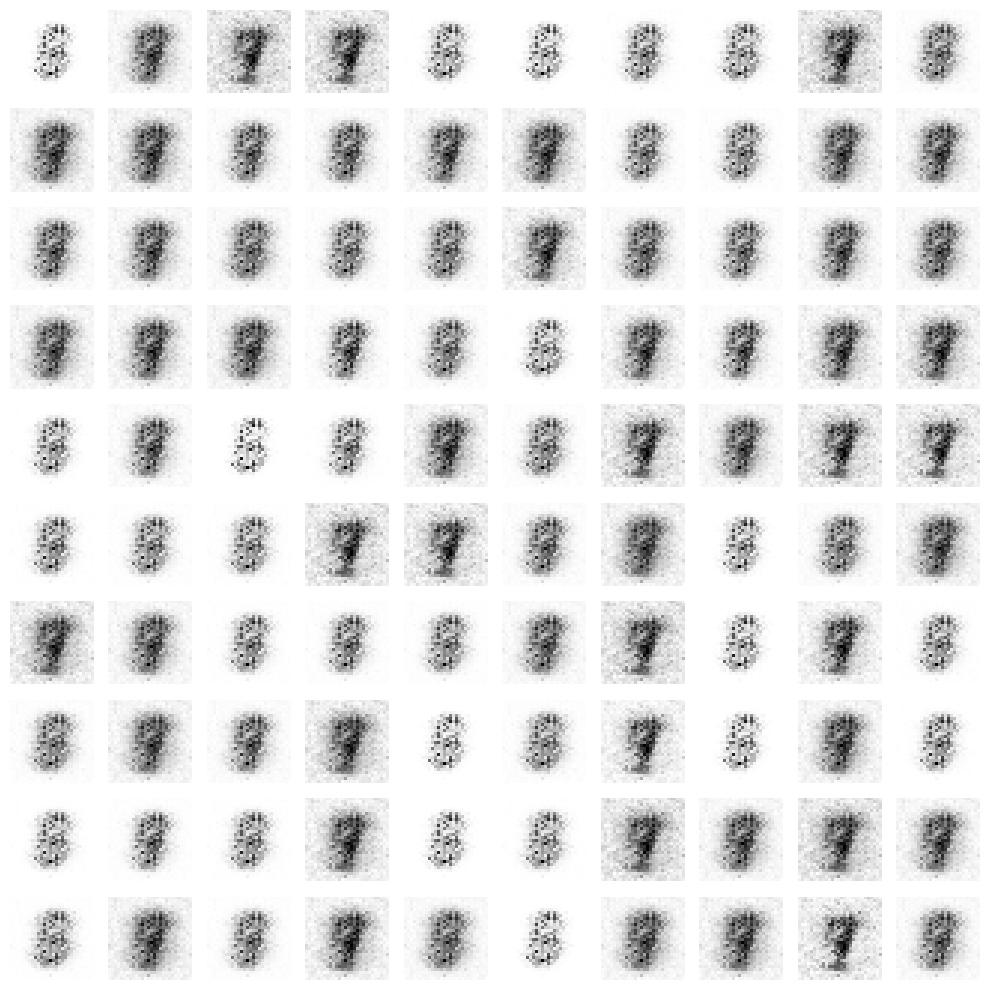

In [18]:
plot_generated_best_images(200, generator)